In [91]:
import numpy as np
from scipy.stats import spearmanr

%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.linear_model import LinearRegression

import sys
sys.path.append("../")
import lgpc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Motivation
We wish to understand the correlation between $\left\{x_1, x_2\right\}$ and $y$ while controlling for $z$. 



# Fiducial data
First, we generate some fiducial data such that $y = y(z)$ and $x_1$ is correlated with $z$ and $x_2$ is uncorrelated with any variable.  

<IPython.core.display.Javascript object>


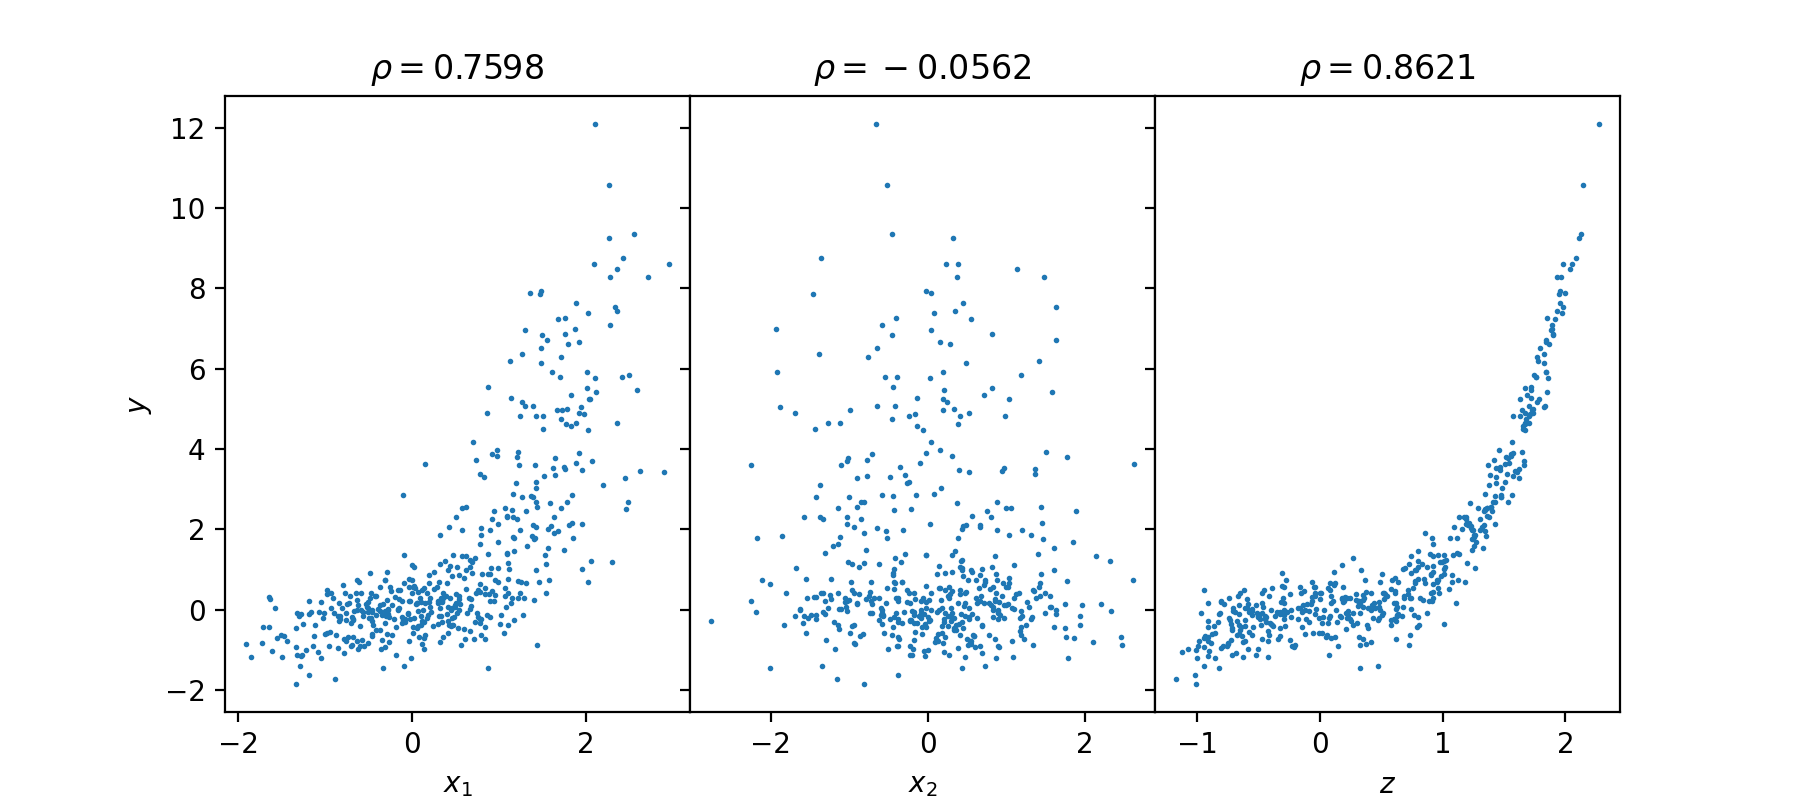

In [167]:
Npoints = 500

z = np.linspace(-1, 2, Npoints) + np.random.normal(0, 0.1, Npoints)
y = z**3 + np.random.normal(0, 0.5, Npoints)


x1 = z + np.random.normal(0, 0.5, Npoints)
x2 = np.random.normal(0, 1, Npoints)



fig, axs = plt.subplots(ncols=3, figsize=(9, 4), sharey=True)
fig.subplots_adjust(wspace=0.0)

axs[0].set_title(r"$\rho = {:.4f}$".format(spearmanr(x1, y)[0]))
axs[0].scatter(x1, y, s=1)

axs[1].set_title(r"$\rho = {:.4f}$".format(spearmanr(x2, y)[0]))
axs[1].scatter(x2, y, s=1)

axs[2].set_title(r"$\rho = {:.4f}$".format(spearmanr(z, y)[0]))
axs[2].scatter(z, y, s=1)


axs[0].set_xlabel(r"$x_1$")
axs[1].set_xlabel(r"$x_2$")
axs[2].set_xlabel(r"$z$")
axs[0].set_ylabel(r"$y$")

fig.show()

# Partial correlation

TODO: descr of PC

## Masks for train-test splitting
We optionally support...

In [168]:
n_splits = 50
test_masks = np.zeros((n_splits, Npoints), dtype=bool)
for i in range(n_splits):
    m = np.random.choice(Npoints, int(Npoints / 5), replace=False)
    test_masks[i, m] = True

## Linear Model

In [169]:
X = np.vstack([x1, x2]).T
model = LinearRegression()
# model = GaussianProcessRegressor(kernel=RBF() + WhiteKernel(), n_restarts_optimizer=1, normalize_y=True)

dxz, dyz, fullout = lgpc.get_reg_residuals(model, X, y, z, test_masks, partial=True)
dxz = lgpc.fold_average(dxz)
dyz = lgpc.fold_average(dyz)

100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 2692.52it/s]


In [170]:
lgpc.partial_correlation(dxz, dyz)

array([[-0.00180577,  0.96787217],
       [-0.01264498,  0.77790218]])

In [192]:
p = x1
peval = np.linspace(p.min(), p.max(), 200)
width = (p.max() - p.min())  / 20
print(width)

cf, ps = lgpc.local_partial_correlation(dxz, dyz, p, peval, width=width, Nrepeat=10)

0.24355221061160087


<IPython.core.display.Javascript object>


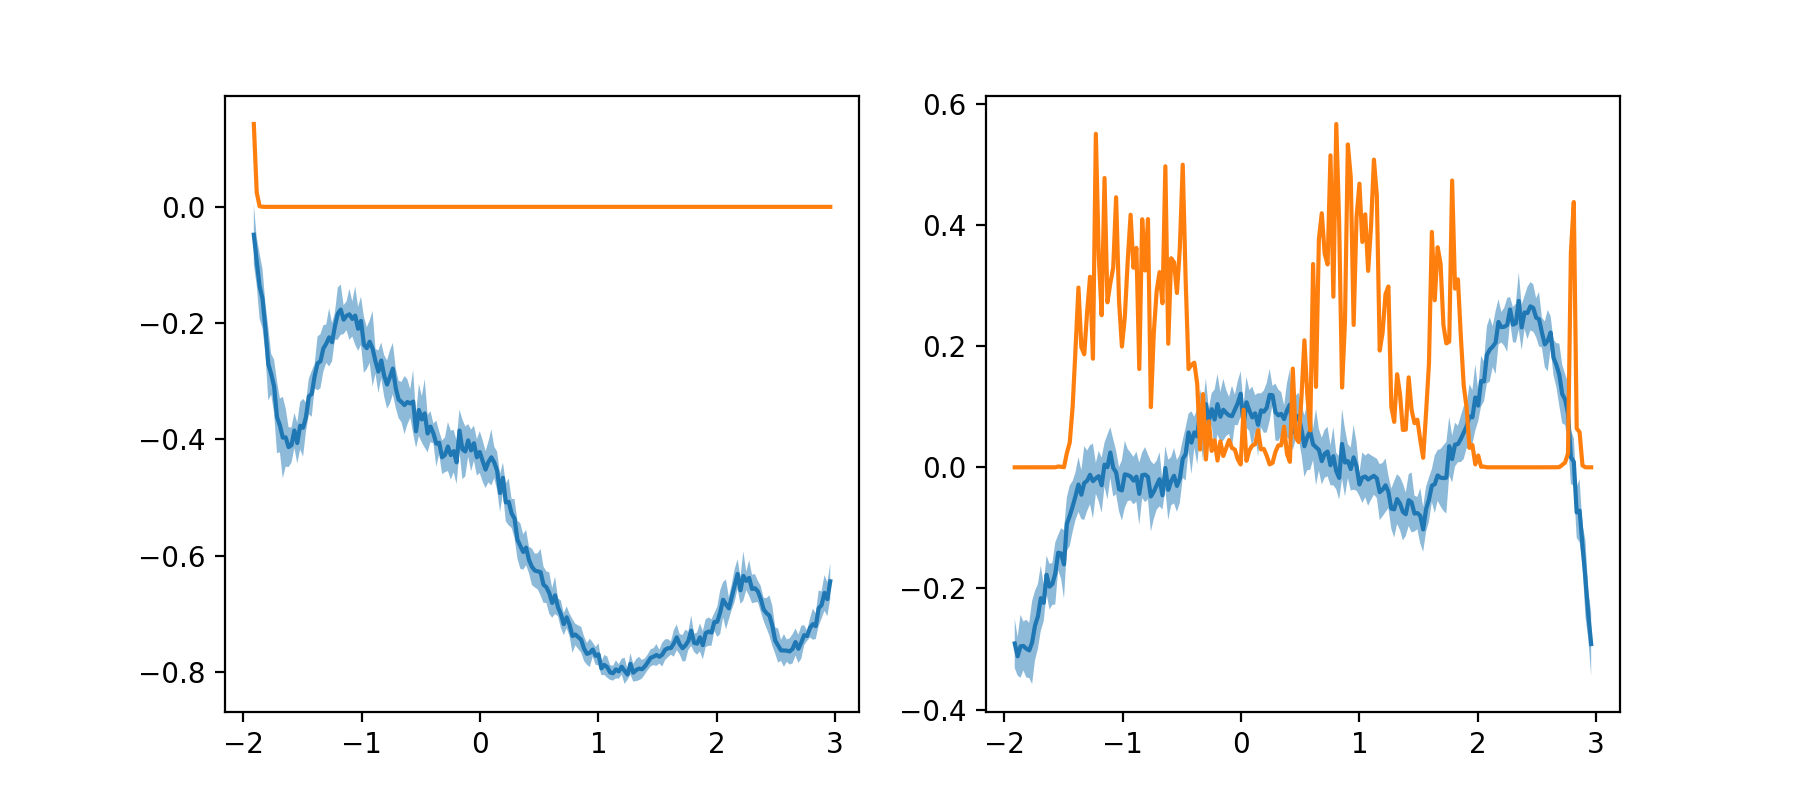

In [193]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 4))
fig.subplots_adjust(hspace=0)

for k in range(2):
    mu = cf[:, k, 0]
    std = cf[:, k, 1]
    ax[k].plot(peval, mu)
    ax[k].fill_between(peval, mu - std, mu + std, alpha=0.5)

    ax[k].plot(peval, ps[:, k])
# ax[0].axhline(0, lw=1)

# ax[0].plot(zeval, np.median(out[..., 1], axis=1))

# ax[1].hist(z, bins="auto")


fig.show()

In [63]:
n_splits = 25

# test_masks = RARinterpret.test_groupshuffle_mask(indxs, n_splits=n_splits, test_size=0.2, random_state=42)
test_masks = RARinterpret.test_shuffle_mask(z.size, n_splits, test_size=0.2)

# gpr = GaussianProcessRegressor(kernel=RBF() + WhiteKernel(), n_restarts_optimizer=1, normalize_y=True)

gpr = LinearRegression()



dxz, dyz, fullout = lgpc.get_reg_residuals(gpr, x, y, z, test_masks, partial=True)
dxz_summ = lgpc.fold_average(dxz)
dyz_summ = lgpc.fold_average(dyz)

100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 1567.03it/s]


In [64]:
p = np.linspace(z.min(), z.max(), 100)
cf, ps = lgpc.local_partial_correlation(dxz_summ, dyz_summ, p=z, peval=p, width=0.2, Nrepeat=30,
                                        kernel="gaussian")

In [65]:
lgpc.partial_correlation(dxz_summ, dyz_summ, corr="pearson")

array([[-0.02543511,  0.18674523]])

<IPython.core.display.Javascript object>


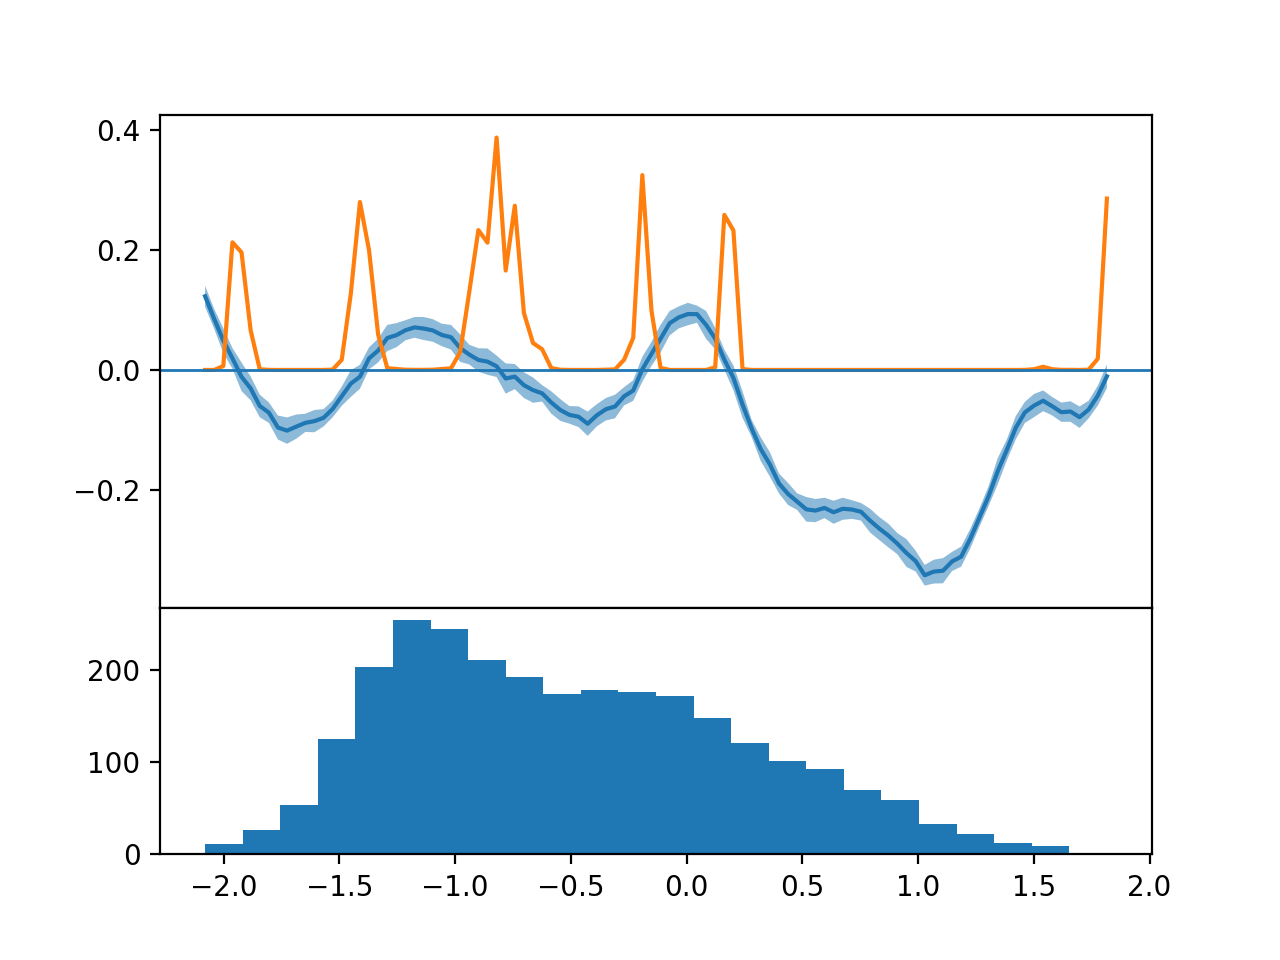

In [66]:
k = 0
mu = cf[:, k, 0]
std = cf[:, k, 1]

fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios": [1, 0.5]})
fig.subplots_adjust(hspace=0)
ax[0].plot(p, mu)
ax[0].fill_between(p, mu - std, mu + std, alpha=0.5)

ax[0].plot(p, ps[:, k])
ax[0].axhline(0, lw=1)

# ax[0].plot(zeval, np.median(out[..., 1], axis=1))

ax[1].hist(z, bins="auto")


plt.show()

In [68]:
spearmanr(dxz_summ[:, k][m], dyz_summ[m])

SpearmanrResult(correlation=-0.05736697970271058, pvalue=0.09386055980256486)

<IPython.core.display.Javascript object>


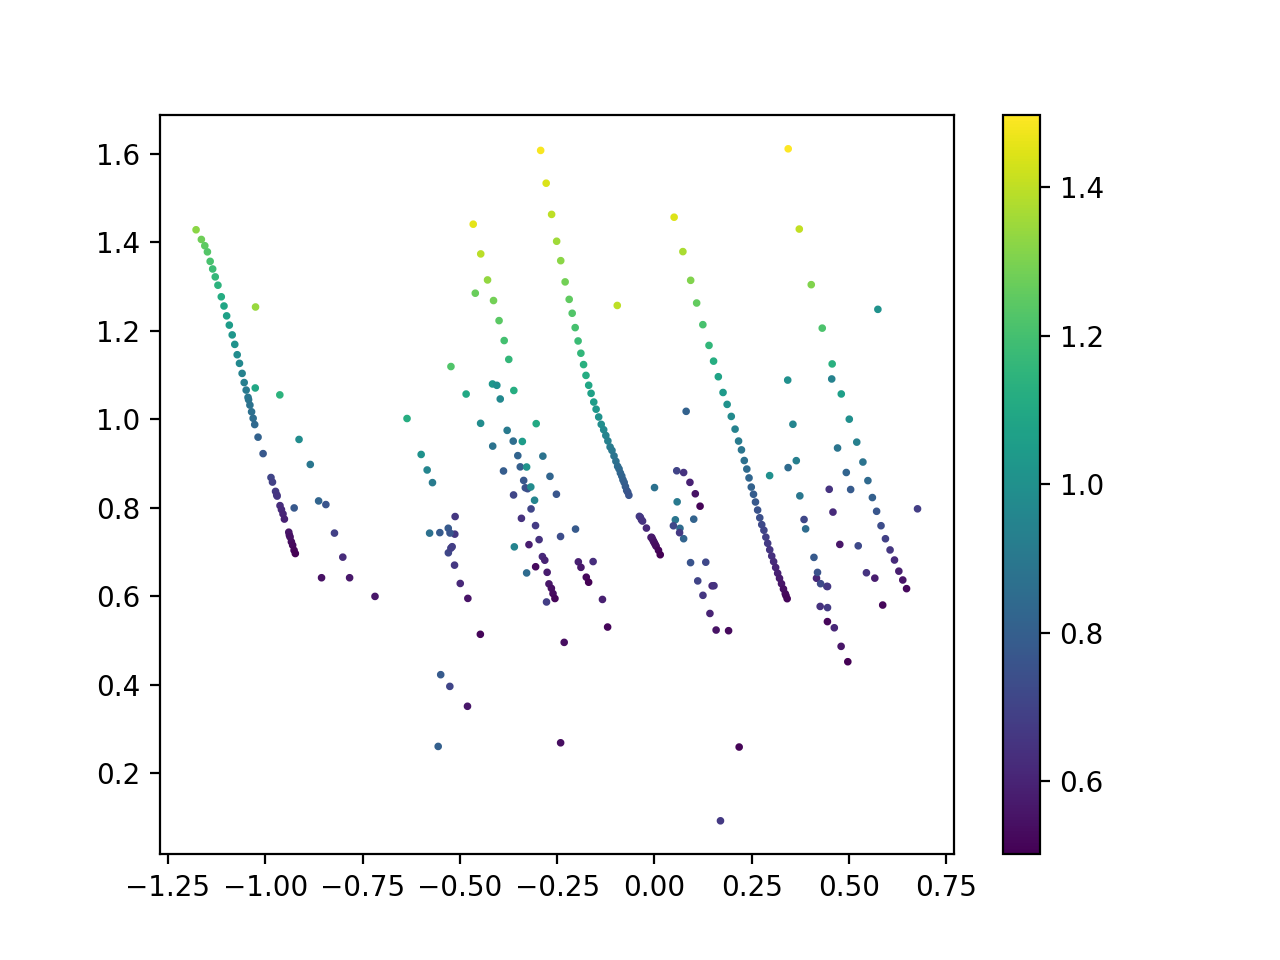

In [69]:


plt.figure()

m = (z > 0.5) & (z < 1.5)

plt.scatter(dxz_summ[:, k][m], dyz_summ[m], s=3, c=z[m])
plt.colorbar()

# plt.scatter(z, x, s=1)
# plt.scatter(z, y, s=1)

plt.show()

In [ ]:
features

In [ ]:
lgpc